In [1]:
import networkx as nx
import pandas as pd
import json

from matplotlib import pyplot as plt
from collections.abc import Mapping
from typing import Any, Literal
from itertools import product
from pathlib import Path

In [2]:
def load_records(result_file_name: str) -> list[Mapping[str, Any]]:
    records: list[Mapping[str, Any]] = []
    with open(Path("./results") / result_file_name, 'r') as file:
        dpth: int = 0
        buff: list[str] = []
        for raw in file:
            line = raw.strip()
            if not line:
                continue
            dpth += line.count('{')
            dpth -= line.count('}')
            buff.append(raw)
            if dpth == 0 and buff:
                chunk = ''.join(buff)
                obj = json.loads(chunk)
                records.append(obj)
                buff = []
    return records

In [3]:
def best_record(records: list[Mapping[str, Any]]) -> Mapping[str, Any]:
    best: Mapping[str, Any] = {}
    for record in records:
        for uid, details in record.items():
            if not best or details['score'] < best['score']:
                best = {'id': uid, **details}
    return best

In [4]:
def load_config(result_file_name: str) -> Mapping[str, Any]:
    stem = Path(result_file_name).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [5]:
def load_experiment(experiment_name: str) -> Mapping[str, Any]:
    result_file_name = f"result_{experiment_name}.jsonl"
    records = load_records(result_file_name)
    best = best_record(records)
    config = load_config(result_file_name)
    return {
        "name": experiment_name,
        "result": best,
        "config": config
    }

In [6]:
def load_all_experiments() -> list[Mapping[str, Any]]:
    experiments: list[Mapping[str, Any]] = []
    for result_file in Path("./results").glob("result_*.jsonl"):
        experiment_name = result_file.stem.removeprefix("result_")
        experiment = load_experiment(experiment_name)
        experiments.append(experiment)
    return experiments

In [7]:
def only_experiments_with(algorithm: Literal["ST", "TF", "GDFS"], weights: tuple[float, float, float, float]) -> list[Mapping[str, Any]]:
    experiments = load_all_experiments()
    filtered: list[Mapping[str, Any]] = []
    for experiment in experiments:
        config = experiment["config"]
        optimizer = config["optimizer"]
        if config["reconstruction_algo"] == algorithm and optimizer["weights"] == list(weights):
            filtered.append(experiment)
    return filtered

In [23]:
all_algorithms: list[str] = ["ST"]
all_weights: list[tuple[float, float, float, float]] = [
    (0.1, 0.3, 0.5, -10.0),
 #   (0.01, 0.5, 0.5, -7.0),
 #   (0.4, 0.2, 0.5, -7.0),
 #   (0.4, 0.2, 0.3, -5.0),
]
all_experiments = []
for algorithm, weights in product(all_algorithms, all_weights):
    print(f"Algorithm: {algorithm}, Weights: {weights}")
    filtered_experiments = only_experiments_with(algorithm, weights)
    all_experiments.extend(filtered_experiments)
    if not filtered_experiments:
        print("No experiments found for this configuration.")
        continue

Algorithm: ST, Weights: (0.1, 0.3, 0.5, -10.0)


In [28]:
import pandas as pd

# if your list is literally in `records`:
# records = [ { ... }, { ... }, … ]

# this will “flatten” all nested dicts into column names separated by dots
df = pd.json_normalize(all_experiments)
cols = ['result.score', 'config.solverName']
df_sub = df[cols]
print(df_sub.head())
print(df.columns.tolist())

    result.score config.solverName
0 -661751.168097          Bayesian
1 -696360.263002          Bayesian
2 -660501.889030          Bayesian
3 -644271.778766          Bayesian
4 -629812.030649          Bayesian
['name', 'result.id', 'result.params.scatter', 'result.params.min_strong_track_length', 'result.params.allowed_missed_modules', 'result.score', 'result.total_ghosts', 'result.overall_ghost_rate', 'result.event_avg_ghost_rate', 'result.clone_percentage', 'result.total_tracks', 'result.time', 'config.solverName', 'config.num_events', 'config.intra_node', 'config.max_runs', 'config.optimizer.max_iterations', 'config.optimizer.objective', 'config.optimizer.nested', 'config.optimizer.weights', 'config.optimizer.learning_rate', 'config.optimizer.target_score', 'config.reconstruction_algo', 'config.optimizer.resolution', 'config.optimizer.inertia', 'config.optimizer.cognitive', 'config.optimizer.social', 'config.optimizer.swarm_size']


config.solverName
Bayesian        -696360.263002
GridSearch      -717280.043607
ParticleSwarm      1492.642957
PolyHoot          15902.063344
Name: result.score, dtype: float64


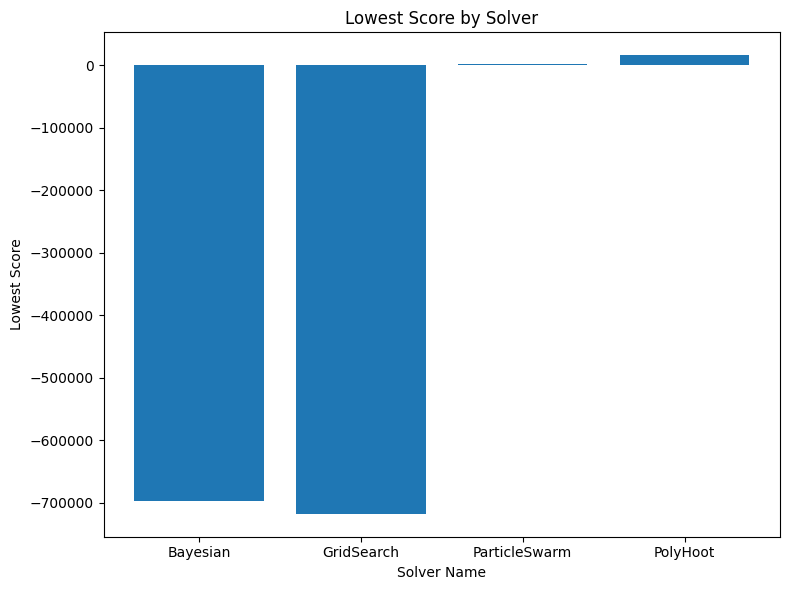

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


# 3. Compute lowest score per solver
min_scores = df_sub.groupby('config.solverName')['result.score'].min()
print(df_sub.groupby('config.solverName')['result.score'].min())

# 4. Plot
plt.figure(figsize=(8,6))
plt.bar(min_scores.index, min_scores.values)
plt.xlabel('Solver Name')
plt.ylabel('Lowest Score')
plt.title('Lowest Score by Solver')
plt.tight_layout()
plt.show()
